# Modelling

## Packages

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import winsound
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, normalize
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import joblib

import xgboost

import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
#from tensorflow.nn import relu, softmax

from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt

print(f" Found and Using {len(tensorflow.config.experimental.list_physical_devices('GPU'))} GPU")

 Found and Using 1 GPU


## Functions

In [2]:
def scale_x_encode_y(x, y):

    scaler_obj = StandardScaler()
    #scaler_obj = MinMaxScaler()
    scaler_obj.fit(x.values)
    x_scaled = scaler_obj.transform(x.values)
    #x_scaled = x.values
    
    encoder = LabelEncoder()
    encoder.fit(y)
    y_encoded = encoder.transform(y)
    y_encoded = utils.to_categorical(y_encoded)
    
    y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
 
    return(x_scaled, y_encoded, y_map, scaler_obj)


def smote_data(x, y):
    oversample = SMOTE()
    smote_x, smote_y = oversample.fit_resample(x, y)

    return(smote_x, smote_y)

def split_data(df, divisor):
    df_tot = df.copy()
    print(f'df_tot count : {len(df_tot)}')

    df1 = df_tot.iloc[int(len(df_tot)/divisor):]
    print(f'df1 count : {len(df1)}')

    df2 = df_tot.iloc[:int(len(df_tot)/divisor)]
    print(f'df2 count : {len(df2)}')
    
    return(df_tot, df1, df2)

def data_prep(df, apply_smote = False):
    x = df.loc[:, df.columns != target_col]
    y = df[target_col]

    if apply_smote:
        x, y = smote_data(x, y)

    print(f'Record count : {len(y)}')
    print('--------------------------')
    print(y.value_counts())
    print('--------------------------')
    print(y.value_counts(normalize=True))
    
    x_scaled, y_encoded, y_map, scaler_obj = scale_x_encode_y(x, y)
    pd.DataFrame(x_scaled).head()
    
    return(x_scaled, y_encoded, y_map, scaler_obj)

## Read Data

In [3]:
remove_cols = ['tick_avg', 'sema', 'ssma', 'lema', 'lsma', 'max_tick', 'min_tick', 'small_sema_slope', 'long_sema_slope']

In [4]:
df = pd.read_csv('data/tab_tick_2019.csv')
#df.drop(remove_cols, axis=1, inplace=True)
df.head(5)

,spread_avg,spread_cls_diff,tick_opn_diff,tick_high_diff,tick_low_diff,tick_cls_diff,tick_avg_diff,tick_sd,tick_ema_10_diff,tick_ema_25_diff,...,tick_ema_75_diff,tick_ema_diff,ema_gap,gain,loss,avg_gain,avg_loss,rsi,tick_slope,direction
0,0.000405,0.00025,0.000025,0.000130,-0.000020,0.000055,0.000035,0.000060,0.000056,0.000071,...,0.000063,0.000053,0.000003,0.000035,0.000000,0.000019,0.000033,36.630037,8.526058,same
1,0.000531,-0.00029,0.000050,0.000065,0.000030,0.000145,0.000057,0.000058,0.000099,0.000021,...,0.000010,0.000027,0.000072,0.000057,0.000000,0.000023,0.000033,41.189802,-3.724729,decrease
2,0.000375,0.00012,0.000145,-0.000010,-0.000275,-0.000430,-0.000132,0.000125,-0.000373,-0.000296,...,-0.000204,-0.000179,-0.000194,0.000000,0.000132,0.000023,0.000043,35.201212,-19.796746,same
3,0.000522,0.00025,-0.000400,-0.000305,-0.000005,-0.000045,-0.000201,0.000065,-0.000097,-0.000086,...,-0.000144,-0.000164,0.000066,0.000000,0.000201,0.000023,0.000043,35.277537,-6.967128,same
4,0.000633,0.00014,-0.000055,-0.000015,-0.000010,0.000070,0.000020,0.000056,0.000092,0.000068,...,0.000061,0.000045,0.000047,0.000020,0.000000,0.000025,0.000037,39.812039,3.870720,increase


In [5]:
target_col = 'direction'
x_scaled, y_encoded, y_map, scaler_obj = data_prep(df, apply_smote = False)
joblib.dump(scaler_obj, 'data/model/scaler_obj.pkl') 
joblib.dump(y_map, 'data/model/y_map.pkl') 

Record count : 291851
--------------------------
same        259793
decrease     16392
increase     15666
Name: direction, dtype: int64
--------------------------
same        0.890156
decrease    0.056166
increase    0.053678
Name: direction, dtype: float64


['data/model/y_map.pkl']

## Neural Network

### Network building

In [6]:
train_x, valid_x, train_y, valid_y = train_test_split(x_scaled, y_encoded,train_size = 0.8,random_state = 1)

In [7]:
model = Sequential([
    Dense(units = 2048, activation='relu', input_shape=(len(train_x[0]),)),
    Dense(units = 1024, activation='relu',),
    Dense(units = 512, activation='relu'),    
    Dense(units = 256, activation='relu'),
    Dense(units = 128, activation='relu'),
    Dense(units = 3, activation='softmax')
])

model.compile(    
    loss=CategoricalCrossentropy(),
    optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.01),
    metrics=CategoricalAccuracy())

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              43008     
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 2,830,595
Trainable params: 2,830,595
Non-trainable params: 0
______________________________________________

### Training

In [8]:
epoch_val         = 10
batch_size_val    = 1024

verbose_val       = 2
workers_val       = -1

In [9]:
model.fit(x=train_x, 
          y=train_y, 
          epochs=epoch_val,
          batch_size = batch_size_val,
          validation_data = (valid_x, valid_y),
          workers= workers_val,
          verbose=verbose_val)

Epoch 1/10
229/229 - 2s - loss: 0.4351 - categorical_accuracy: 0.8881 - val_loss: 0.3934 - val_categorical_accuracy: 0.8894
Epoch 2/10
229/229 - 2s - loss: 0.3850 - categorical_accuracy: 0.8916 - val_loss: 0.3898 - val_categorical_accuracy: 0.8898
Epoch 3/10
229/229 - 2s - loss: 0.3831 - categorical_accuracy: 0.8917 - val_loss: 0.3898 - val_categorical_accuracy: 0.8897
Epoch 4/10
229/229 - 2s - loss: 0.3822 - categorical_accuracy: 0.8919 - val_loss: 0.3887 - val_categorical_accuracy: 0.8897
Epoch 5/10
229/229 - 2s - loss: 0.3816 - categorical_accuracy: 0.8920 - val_loss: 0.3879 - val_categorical_accuracy: 0.8898
Epoch 6/10
229/229 - 2s - loss: 0.3812 - categorical_accuracy: 0.8921 - val_loss: 0.3875 - val_categorical_accuracy: 0.8898
Epoch 7/10
229/229 - 2s - loss: 0.3810 - categorical_accuracy: 0.8920 - val_loss: 0.3874 - val_categorical_accuracy: 0.8898
Epoch 8/10
229/229 - 2s - loss: 0.3808 - categorical_accuracy: 0.8921 - val_loss: 0.3874 - val_categorical_accuracy: 0.8897
Epoch 9/

### DNN

In [10]:
predictions = model.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

              precision    recall  f1-score   support

    decrease       0.42      0.04      0.06      3354
    increase       0.40      0.01      0.03      3158
        same       0.89      1.00      0.94     51859

    accuracy                           0.89     58371
   macro avg       0.57      0.35      0.35     58371
weighted avg       0.84      0.89      0.84     58371



In [11]:
model.save('data/model/model_dnn.h5') 
model_new = load_model('data/model/model_dnn.h5')

### DNN Prediction

Record count : 260475
--------------------------
same        165914
decrease     47378
increase     47183
Name: direction, dtype: int64
--------------------------
same        0.636967
decrease    0.181891
increase    0.181142
Name: direction, dtype: float64
              precision    recall  f1-score   support

    decrease       0.49      0.01      0.02     47378
    increase       0.51      0.01      0.01     47183
        same       0.64      1.00      0.78    165914

    accuracy                           0.64    260475
   macro avg       0.55      0.34      0.27    260475
weighted avg       0.59      0.64      0.50    260475



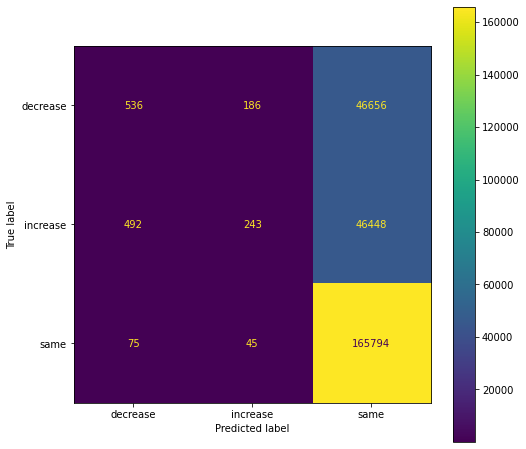

In [12]:
df1 = pd.read_csv('data/tab_tick_2018.csv')
#df1.drop(remove_cols, axis=1, inplace=True)

x_scaled1, y_encoded1, y_map1, scaler_obj_1 = data_prep(df1, apply_smote = False)

predictions = model_new.predict(x_scaled1)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(y_encoded1, axis = -1)

df1['predictions'] = [y_map1[k] for k in rounded_predictions]
df1.to_csv('data/tab_tick_2018_res.csv')

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map1.values()))

fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(rounded_valid_y, rounded_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_map1.values())
disp.plot(ax=ax)

live_df = pd.read_csv('data/live_preds.csv')
live_df.drop(remove_cols, axis=1, inplace=True)
del live_df['predicted_direction']

model_new = load_model('data/model/model_dnn.h5')    
scaler_obj = joblib.load('data/model/scaler_obj.pkl')
y_map = joblib.load('data/model/y_map.pkl') 

x_scaled = scaler_obj.transform(live_df.values)
predictions = model_new.predict(x_scaled) 
rounded_predictions = np.argmax(predictions, axis = -1)

#live_df['predictions'] = y_map[data['rounded_predictions'][0]]
live_df['predictions'] = [y_map[k] for k in rounded_predictions]

print(y_map)
live_df['predictions'].value_counts()